In [1]:
from pyspark.sql import functions as F
from pyspark.sql.functions import count, avg, sum, date_format
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Start Spark Session
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder.appName("MAST30034 Project 2 BNPL")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

22/09/12 12:40:45 WARN Utils: Your hostname, Jas-Mins-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.13.198.39 instead (on interface en0)
22/09/12 12:40:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/12 12:40:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# reading the datasets
consumer = spark.read.csv("../data/tables/tbl_consumer.csv", header=True, sep="|")
details = spark.read.parquet("../data/tables/consumer_user_details.parquet")
merchants = spark.read.parquet("../data/tables/tbl_merchants.parquet")
transactions = spark.read.parquet("../data/tables/transactions_20210228_20210827_snapshot/")

In [4]:
# rename columns in merchants and consumer df
merchants = merchants.withColumnRenamed('name', 'merchant_name')
consumer = consumer.withColumnRenamed('name', 'consumer_name')

In [5]:
# joining datasets
consumer_user = consumer.join(details, on="consumer_id")
consumer_transactions = consumer_user.join(transactions, on="user_id")
consumer_merchants = consumer_transactions.join(merchants, on="merchant_abn")

# list of columns
column_names = consumer_merchants.columns

In [6]:
# consumer_merchants.count() = 3494038

In [7]:
consumer_merchants.limit(3)

merchant_abn,user_id,consumer_id,consumer_name,address,state,postcode,gender,dollar_value,order_id,order_datetime,merchant_name,tags
33064796871,7,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,373.0873675184212,fe188788-b89f-4dd...,2021-08-20,Curabitur Massa C...,((computer progra...
68435002949,7,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,232.5364986739752,b4a89891-a113-45e...,2021-08-20,Aliquam Eu Inc.,[(artist supply a...
41944909975,7,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,30.910755230234322,302ae628-8eba-4a5...,2021-08-20,Et Nunc Consulting,"([books, periodic..."


In [9]:
# null values
null_vals = {col: consumer_merchants.filter(F.col(col).isNull()).count()
                for col in column_names}
null_vals

{'merchant_abn': 0,
 'user_id': 0,
 'consumer_id': 0,
 'consumer_name': 0,
 'address': 0,
 'state': 0,
 'postcode': 0,
 'gender': 0,
 'dollar_value': 0,
 'order_id': 0,
 'order_datetime': 0,
 'merchant_name': 0,
 'tags': 0}

In [78]:
# zero values
consumer_merchants.filter(F.col('merchant_abn') == 0)

merchant_abn,user_id,consumer_id,consumer_name,address,state,postcode,gender,dollar_value,order_id,order_datetime,merchant_name,tags


In [79]:
# dates out of range
consumer_merchants.filter(F.col('order_datetime').between('2021-02-28', '2021-08-27')).count()

3494038

Text(0, 0.5, 'number of transactions')

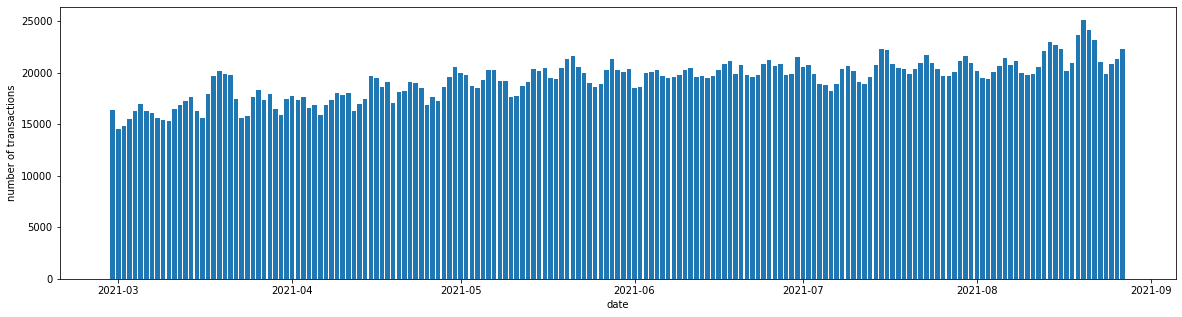

In [102]:
# number of transactions by day
daily_transaction_frequency = consumer_merchants.groupBy('order_datetime').count()
daily_tf = daily_transaction_frequency.toPandas()
fig = plt.figure()
fig.set_size_inches(20, 5)
plt.bar(daily_tf['order_datetime'], daily_tf['count'])
plt.xlabel('date')
plt.ylabel('number of transactions')

Text(0, 0.5, 'number of transactions')

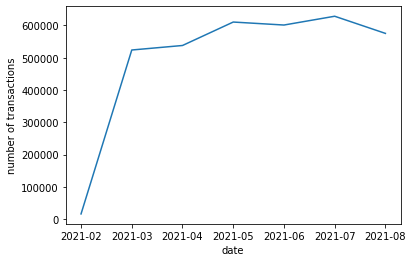

In [110]:
# number of transactions by month
monthly_transaction_frequency = consumer_merchants.select(F.date_format('order_datetime','yyyy-MM').alias('month')).groupby('month').count()
monthly_transaction_frequency = monthly_transaction_frequency.orderBy('month')
monthly_tf = monthly_transaction_frequency.toPandas()
plt.plot(monthly_tf['month'], monthly_tf['count'])
plt.xlabel('date')
plt.ylabel('number of transactions')

Text(0, 0.5, 'average dollar value')

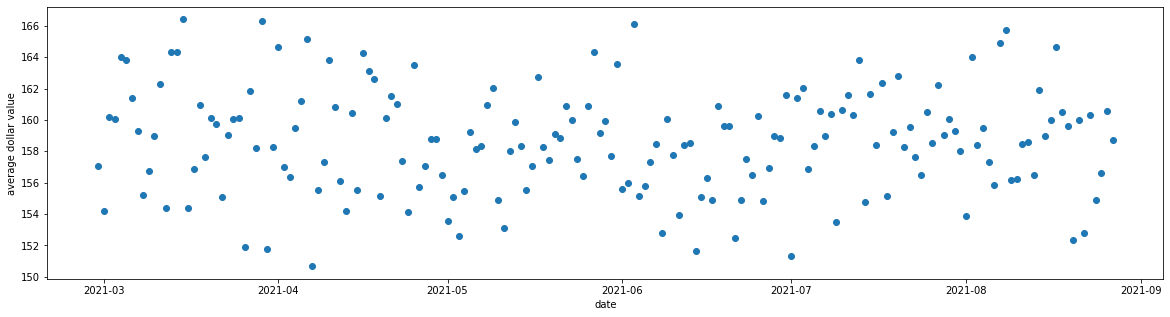

In [82]:
# average transaction value by day
daily_transaction_sum = consumer_merchants.groupBy('order_datetime').agg(avg('dollar_value').alias('average_dollar_value')).toPandas()
fig = plt.figure()
fig.set_size_inches(20, 5)
plt.scatter(daily_transaction_sum['order_datetime'], daily_transaction_sum['average_dollar_value'])
plt.xlabel('date')
plt.ylabel('average dollar value')

Text(0, 0.5, 'average_dollar_value')

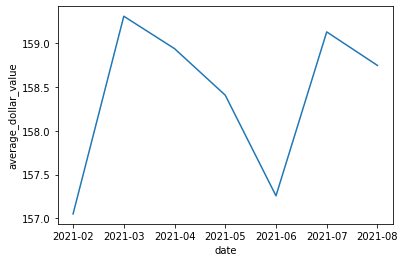

In [115]:
# average transactions value by month
monthly_transaction_sum = consumer_merchants.select(F.date_format('order_datetime','yyyy-MM').alias('month'), 'dollar_value').groupby('month').agg(avg('dollar_value').alias('average_dollar_value'))
monthly_transaction_sum = monthly_transaction_sum.orderBy('month')
monthly_ts = monthly_transaction_sum.toPandas()
plt.plot(monthly_ts['month'], monthly_ts['average_dollar_value'])
plt.xlabel('date')
plt.ylabel('average_dollar_value')

Text(0, 0.5, 'average value')

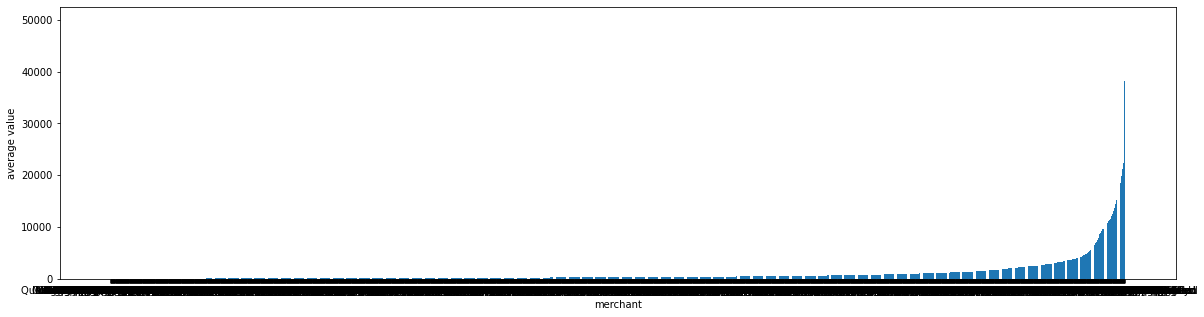

In [116]:
# average transaction value by merchant
merchant_transactions = consumer_merchants.groupBy('merchant_name').agg(avg('dollar_value').alias('average_value')).orderBy('average_value').toPandas()
fig = plt.figure()
fig.set_size_inches(20, 5)
plt.bar(merchant_transactions['merchant_name'], merchant_transactions['average_value'])
plt.xlabel('merchant')
plt.ylabel('average value')

In [83]:
merchant_transactions.filter(F.col('average_value') < 35).count()

127

In [126]:
# average transaction value by tags
tag_value = consumer_merchants.groupBy('tags').agg(avg('dollar_value').alias('average_value')).orderBy('average_value')
# fig = plt.figure()
# fig.set_size_inches(20, 5)
# plt.bar(tag_value['tags'], tag_value['average_value'])
# plt.xlabel('merchant')
# plt.ylabel('average value')

In [132]:
tag_value.count()

3910

In [131]:
tag_value.show(truncate=False)

# needs cleaning

+-------------------------------------------------------------------------+------------------+
|tags                                                                     |average_value     |
+-------------------------------------------------------------------------+------------------+
|[[gift, card, novelty, and souvenir shops], [c], [take rate: 2.26]]      |10.83996215945744 |
|[[digital goods: books, movies, music], [c], [take rate: 2.52]]          |11.39543110447357 |
|((tent and awning shops), (b), (take rate: 3.48))                        |12.594530282797015|
|[(tEnt and awning shops), (b), (take rate: 4.08)]                        |13.129463332505008|
|[(tent and  Awning shops), (a), (take rate: 5.96)]                       |13.496950987190855|
|[(tent and awning shops), (b), (take rate: 4.04)]                        |13.566331760261406|
|((tent and awning shops), (b), (take rate: 5.05))                        |13.766548143107327|
|[[tent and awning shops], [c], [take rate: 2.22]]

In [13]:
df = consumer_merchants.toPandas()

Text(0, 0.5, 'dollar_value')

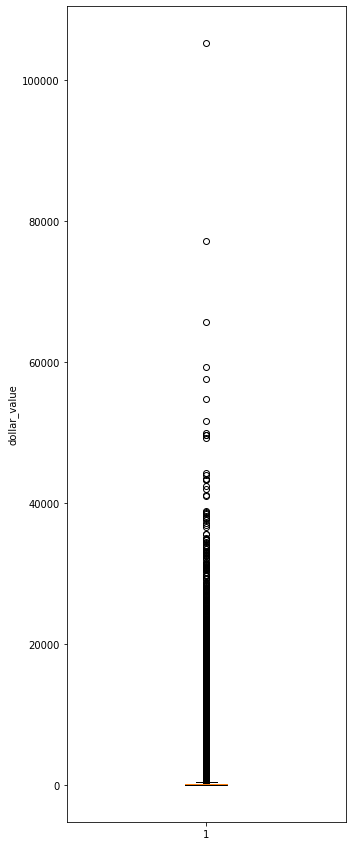

In [14]:
# y_axis = np.arange(100000)
fig = plt.figure()
fig.set_size_inches(5, 15)
plt.boxplot(df['dollar_value'])
plt.ylabel('dollar_value')
# plt.yticks(y_axis, step=10000)

Text(0, 0.5, 'dollar_value')

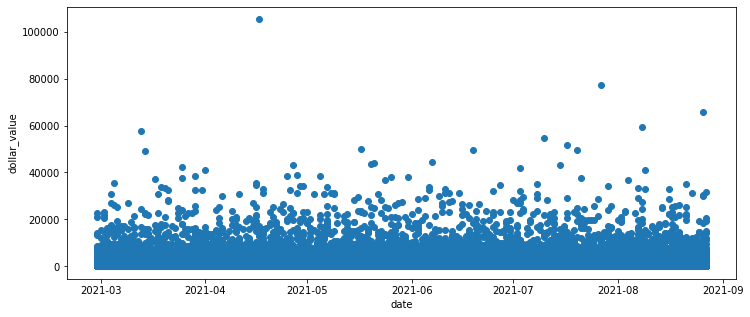

In [19]:
fig = plt.figure()
fig.set_size_inches(12, 5)
plt.scatter(df['order_datetime'], df['dollar_value'])
plt.xlabel('date')
plt.ylabel('dollar_value')

Text(0, 0.5, 'dollar_value')

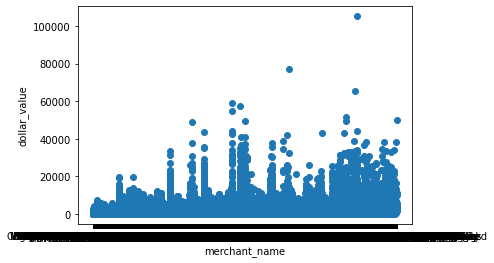

In [28]:
# fig = plt.figure()
# fig.set_size_inches(30, 5)
plt.scatter(df['merchant_name'], df['dollar_value'])
plt.xlabel('merchant_name')
plt.ylabel('dollar_value')

Text(0, 0.5, 'dollar_value')

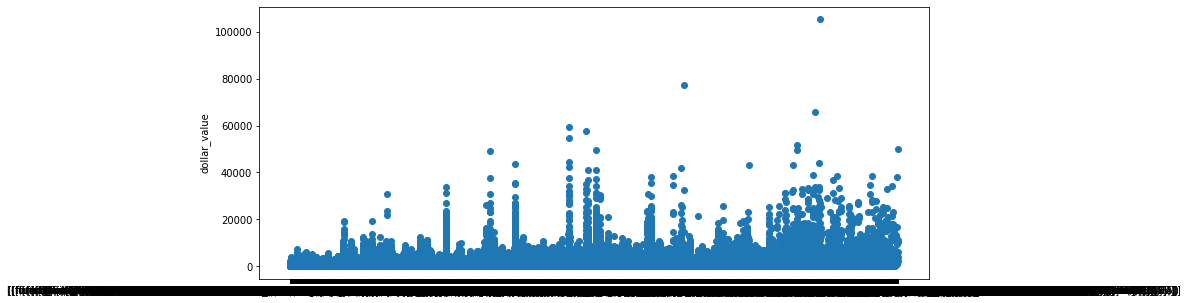

In [118]:
fig = plt.figure()
fig.set_size_inches(12, 5)
plt.scatter(df['tags'], df['dollar_value'])
# plt.xlabel('tags')
plt.ylabel('dollar_value')